In [1]:
"""
Steps:
    1) Load the csv file and create train + val dataset from the csv file (with the optical flow + the random illumination)
    2) Define the model
    3) Write the train function which trains + evals + graph
"""

'\nSteps:\n    1) Load the csv file and create train + val dataset from the csv file (with the optical flow + the random illumination)\n    2) Define the model\n    3) Write the train function which trains + evals + graph\n'

In [2]:
import numpy as np
import torch
from torchsummary import summary
import math
import time
import copy
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import cv2
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook
import pandas as pd
import ipywidgets as widgets
from IPython.html.widgets import *
import pickle
import h5py 
import torch.nn as nn
import torch.nn.functional as F


%matplotlib inline


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [3]:
# constants
DATA_PATH = '/home/ubuntu/repositories/speed-challenge/data'
TRAIN_VIDEO = os.path.join(DATA_PATH, 'train.mp4') #'drive.mp4' 'train.mp4'
TEST_VIDEO = os.path.join(DATA_PATH, 'test.mp4')
PREPARED_DATA_PATH = '/home/ubuntu/repositories/speed-challenge/prepared-data'
PREPARED_IMGS_TRAIN = os.path.join(PREPARED_DATA_PATH, 'train_imgs')
PREPARED_IMGS_TEST = os.path.join(PREPARED_DATA_PATH, 'test_imgs')
ASSETS_PATH = '/home/ubuntu/repositories/speed-challenge/assets'

TRAIN_FRAMES = 20400
TEST_FRAMES = 10798

seeds = [1, 2, 3, 5, 8, 13, 21, 34, 55, 89, 144]


# hyperparameters
batch_size = 16
num_epochs = 50

model_name = 'simple-cnn'
run_name = 'model={}-batch_size={}-num_epoch={}'.format(model_name,
                                                                          batch_size,
                                                                          num_epochs)

assets_filepath = os.path.join(ASSETS_PATH, 'model_assets' , run_name)
weights_loc = os.path.join(assets_filepath,'weights.h5')
history_loc=  os.path.join(assets_filepath,'history.p')
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
run_name

'model=simple-cnn-batch_size=16-num_epoch=50'

In [5]:
device

device(type='cuda', index=0)

In [6]:
train_meta = pd.read_csv(os.path.join(PREPARED_DATA_PATH, 'train_meta.csv')) #train2_meta
print('shape: ', train_meta.shape)

shape:  (20400, 3)


In [7]:
# note: there is a chance that points might appear again. as n

def train_validation_split(dframe, seed_val):
    """
    Randomly shuffle pairs of rows in the dataframe, separates train and validation data
    generates a uniform random variable 0->9, gives 20% chance to append to valid data, otherwise train_data
    return tuple (train_data, valid_data) dataframes
    """
    train_data = pd.DataFrame()
    valid_data = pd.DataFrame()
    np.random.seed(seed_val)
    for i in tqdm_notebook(range(len(dframe) - 1)):
        idx1 = np.random.randint(len(dframe) - 1)
        idx2 = idx1 + 1
        
        
        row1 = dframe.iloc[[idx1]].reset_index()
        row2 = dframe.iloc[[idx2]].reset_index()
        
        randInt = np.random.randint(9)
        if 0 <= randInt <= 1:
            valid_frames = [valid_data, row1, row2]
            valid_data = pd.concat(valid_frames, axis = 0, join = 'outer', ignore_index=False)
        if randInt >= 2:
            train_frames = [train_data, row1, row2]
            train_data = pd.concat(train_frames, axis = 0, join = 'outer', ignore_index=False)
    return train_data, valid_data

In [8]:
train_data, validation_data = train_validation_split(train_meta, seeds[0])

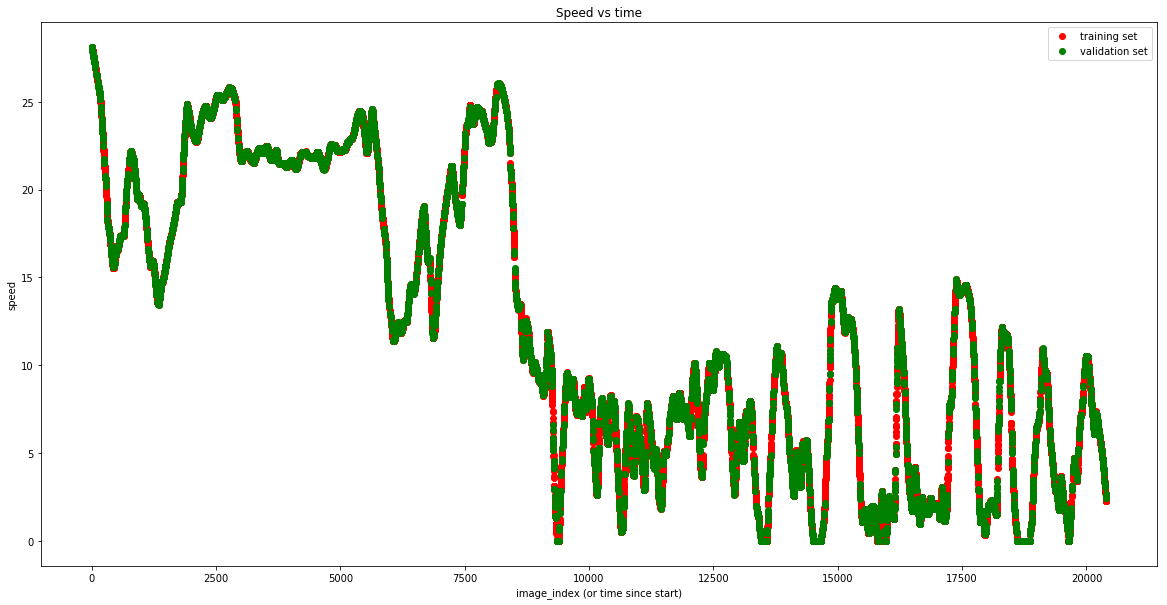

----
validation_data:  (9032, 4)
train_data:  (31766, 4)


In [9]:
fig, ax = plt.subplots(figsize=(20,10))
plt.plot(train_data.sort_values(['image_index'])[['image_index']], train_data.sort_values(['image_index'])[['speed']], 'ro')
plt.plot(validation_data.sort_values(['image_index'])[['image_index']], validation_data.sort_values(['image_index'])[['speed']], 'go')
plt.xlabel('image_index (or time since start)')
plt.ylabel('speed')
plt.title('Speed vs time')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()
plt.close()

print('----')
print('validation_data: ', validation_data.shape)
print('train_data: ', train_data.shape)

In [10]:
"""
Data transformation
"""


'\nData transformation\n'

In [11]:
train_data.head()

,index,image_path,image_index,speed
0,235,/home/ubuntu/repositories/speed-challenge/prep...,235,22.497131
0,236,/home/ubuntu/repositories/speed-challenge/prep...,236,22.412535
0,17289,/home/ubuntu/repositories/speed-challenge/prep...,17289,8.442924
0,17290,/home/ubuntu/repositories/speed-challenge/prep...,17290,8.477479
0,16332,/home/ubuntu/repositories/speed-challenge/prep...,16332,9.099360


In [12]:
def change_brightness(image, bright_factor):
    """
    Augments the brightness of the image by multiplying the saturation by a uniform random variable
    Input: image (RGB)
    returns: image with brightness augmentation
    """
    
    hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    # perform brightness augmentation only on the second channel
    hsv_image[:,:,2] = hsv_image[:,:,2] * bright_factor
    
    # change back to RGB
    image_rgb = cv2.cvtColor(hsv_image, cv2.COLOR_HSV2RGB)
    return image_rgb

In [13]:
def opticalFlowDense(image_current, image_next):
    """
    input: image_current, image_next (RGB images)
    calculates optical flow magnitude and angle and places it into HSV image
    * Set the saturation to the saturation value of image_next
    * Set the hue to the angles returned from computing the flow params
    * set the value to the magnitude returned from computing the flow params
    * Convert from HSV to RGB and return RGB image with same size as original image
    """
    gray_current = cv2.cvtColor(image_current, cv2.COLOR_RGB2GRAY)
    gray_next = cv2.cvtColor(image_next, cv2.COLOR_RGB2GRAY)
    
    
    hsv = np.zeros((66, 220, 3))
    # set saturation
    hsv[:,:,1] = cv2.cvtColor(image_next, cv2.COLOR_RGB2HSV)[:,:,1]
 
    # Flow Parameters
#     flow_mat = cv2.CV_32FC2
    flow_mat = None
    image_scale = 0.5
    nb_images = 1
    win_size = 15
    nb_iterations = 2
    deg_expansion = 5
    STD = 1.3
    extra = 0

    # obtain dense optical flow paramters
    flow = cv2.calcOpticalFlowFarneback(gray_current, gray_next,  
                                        flow_mat, 
                                        image_scale, 
                                        nb_images, 
                                        win_size, 
                                        nb_iterations, 
                                        deg_expansion, 
                                        STD, 
                                        0)
                                        
        
    # convert from cartesian to polar
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])  
        
    # hue corresponds to direction
    hsv[:,:,0] = ang * (180/ np.pi / 2)
    
    # value corresponds to magnitude
    hsv[:,:,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
    
    # convert HSV to float32's
    hsv = np.asarray(hsv, dtype= np.float32)
    rgb_flow = cv2.cvtColor(hsv,cv2.COLOR_HSV2RGB)

    
    return rgb_flow

In [14]:
def preprocess_image(image):
    """
    preprocesses the image
    
    input: image (480 (y), 640 (x), 3) RGB
    output: image (shape is (220, 66, 3) as RGB)
    
    This stuff is performed on my validation data and my training data
    Process: 
             1) Cropping out black spots
             3) resize to (220, 66, 3) if not done so already from perspective transform
    """
    # Crop out sky (top) (100px) and black right part (-90px)
    #image_cropped = image[100:440, :-90] # -> (380, 550, 3) #v2 for data
    image_cropped = image[25:375, :] #v1 for data
    
    image = cv2.resize(image_cropped, (220, 66), interpolation = cv2.INTER_AREA)
    
    return image

original image shape: (480, 640, 3)


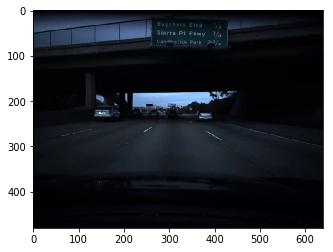

post processed image: (66, 220, 3)


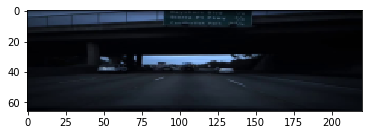

In [15]:
img=mpimg.imread(train_meta['image_path'][10])
print('original image shape:', img.shape)
plt.imshow(img)
plt.show()
plt.close()

post_img = preprocess_image(img)
print('post processed image:', post_img.shape)
plt.imshow(post_img)
plt.show()
plt.close()

In [16]:
"""
Create the dataset class
"""

'\nCreate the dataset class\n'

In [17]:
def load_and_preprocess_image(path, speed, random_brightness = False, bright_factor = 0):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if random_brightness:
        img = change_brightness(img, bright_factor)    
    img = preprocess_image(img)
    return img, speed

In [18]:
class SpeedDataset(Dataset):
    """Speed Challenge dataset."""
    def __init__(self, data, random_brightness = False, transform=None, debug=False):
        """
        Args:
            data (Panda.DataFrame): DataFrame with image_index, speed and image_path
            randomBrightness (boolean, optional): randomize the brightness
        """
        self.data = data
        self.random_brightness = random_brightness
        self.transform = transform
        self.debug = debug

    def __len__(self):
        
        return len(self.data) - 1

    def __getitem__(self, idx):
            # Generate a random bright factor to apply to both images
            bright_factor = 0.2 + np.random.uniform()
            row_now = self.data.iloc[[idx]].reset_index()
            row_prev = self.data.iloc[[idx - 1]].reset_index()
            row_next = self.data.iloc[[idx + 1]].reset_index()
            
            # Find the 3 respective times to determine frame order (current -> next)
            
            time_now = row_now['image_index'].values[0]
            time_prev = row_prev['image_index'].values[0]
            time_next = row_next['image_index'].values[0]
            
            if abs(time_now - time_prev) == 1 and time_now > time_prev:
                row1 = row_prev
                row2 = row_now
                
            elif abs(time_next - time_now) == 1 and time_next > time_now:
                row1 = row_now
                row2 = row_next
            else:
                print('Error generating row')    
                
            x1, y1 = load_and_preprocess_image(row1['image_path'].values[0],
                                                row1['speed'].values[0],
                                                   random_brightness = self.random_brightness,
                                               bright_factor=bright_factor)
            
                # preprocess another image
            x2, y2 = load_and_preprocess_image(row2['image_path'].values[0], 
                                                row2['speed'].values[0],
                                                   random_brightness = self.random_brightness,
                                               bright_factor=bright_factor)
                
           
            # compute optical flow send in images as RGB
            rgb_diff = opticalFlowDense(x1, x2)
            #Swap the axes so that torch is happy
            rgb_diff = np.swapaxes(rgb_diff,0,2)
            rgb_diff = (rgb_diff / 127.5)
            # calculate mean speed
            y = np.float32(np.mean([y1, y2]))
            
            if self.transform:
                y = self.transform(y)
            
            if self.debug:
                #X1 and X2 axis have not been swapped. Can be shown as is
                return rgb_diff, y, x1, x2
            return  rgb_diff, y

In [19]:
class SyntheticDataset(Dataset):
    def __init__(self):
        pass
    def __len__(self):
        return 3
    def __getitem__(self, idx):
        if idx ==0:
            a = np.zeros((3,220,66), dtype=np.float32)
            a[0,:,:] = 255
            return a, np.array([10], dtype=np.float32)
        if idx ==1:
            a = np.zeros((3,220,66), dtype=np.float32)
            a[1,:,:] = 255
            return a, np.array([20], dtype=np.float32)
        if idx ==2:
            a = np.zeros((3,220,66), dtype=np.float32)
            a[2,:,:] = 255
            return a, np.array([30], dtype=np.float32)
    

0 float32 22.454832


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


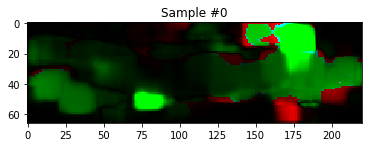

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1 float32 22.454832


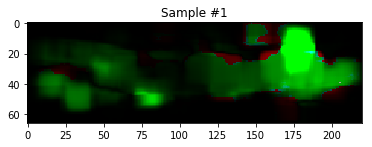

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2 float32 8.460201


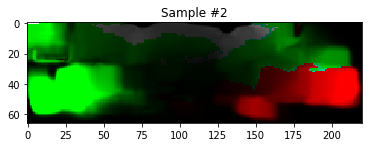

3 float32 8.460201


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


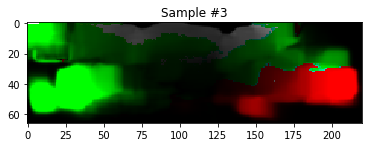

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4 float32 9.111656


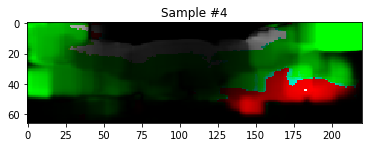

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5 float32 9.111656


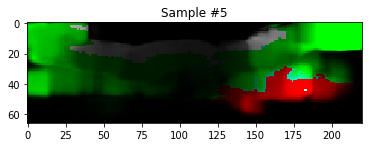

In [20]:
speed_dataset_train_debug = SpeedDataset(data=train_data,
                                    random_brightness=True, debug=True)
speed_dataset_train = SpeedDataset(data=train_data,
                                    random_brightness=True)
speed_dataset_train_overfit = SpeedDataset(data=train_data.head(4),
                                    random_brightness=False)
speed_dataset_validation = SpeedDataset(data=validation_data)

synthetic_dataset = SyntheticDataset()

fig = plt.figure()

for i in range(6):
    flow, speed = speed_dataset_train[i]
    
    print(i, flow.dtype, speed)
    #Swap axes to show
    flow = np.swapaxes(flow,0,2)
    plt.title('Sample #{}'.format(i))
    plt.imshow(flow)
    plt.show()

In [21]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #Conv 1
        self.conv1 = nn.Conv2d(3, 24, 5, stride=2)
        torch.nn.init.xavier_uniform_(self.conv1.weight)
        #Conv 2
        self.conv2 = nn.Conv2d(24, 36, 5, stride=2)
        torch.nn.init.xavier_uniform_(self.conv2.weight)
        #Conv 3
        self.conv3 = nn.Conv2d(36, 48, 5, stride=2)
        torch.nn.init.xavier_uniform_(self.conv3.weight)
        #Conv 4
        self.conv4 = nn.Conv2d(48, 64, 3)
        torch.nn.init.xavier_uniform_(self.conv4.weight)
        #Conv 5
        self.conv5 = nn.Conv2d(64, 64, 3)
        torch.nn.init.xavier_uniform_(self.conv5.weight)
        #Fully connected
        self.fc1 = nn.Linear(20 * 64, 100)
        self.fc2 = nn.Linear(100, 50)
        self.fc3 = nn.Linear(50, 10)
        self.fc4 = nn.Linear(10, 1)

    def forward(self, x):
        x = (F.elu(self.conv1(x)))
        x = (F.elu(self.conv2(x)))
        x = (F.elu(self.conv3(x)))
        x = (F.elu(self.conv4(x)))
        x = (F.elu(self.conv5(x)))
        x = x.view(-1, 20 * 64)
        x = F.elu(self.fc1(x))
        x = F.elu(self.fc2(x))
        x = F.elu(self.fc3(x))
        x = self.fc4(x)
        return x

net = Net().float().to(device)
#model = nn.DataParallel(net)
model = net

In [22]:
#Create directories if they do not exist
if not os.path.exists(assets_filepath):
    os.makedirs(assets_filepath)

In [23]:
#Dataset Loaders
dataloader_train = DataLoader(speed_dataset_train, batch_size=batch_size, shuffle=True, num_workers=4)
# dataloader_train = DataLoader(speed_dataset_train_overfit, batch_size=batch_size, shuffle=True, num_workers=4)
# dataloader_train = DataLoader(synthetic_dataset, batch_size=batch_size, shuffle=True, num_workers=1)
dataloader_validation = DataLoader(speed_dataset_validation, batch_size=batch_size, shuffle=True, num_workers=4)
dataloaders = {
    "train": dataloader_train,
    "validation": dataloader_validation
}

In [24]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, validation=True, debug=False):
    since = time.time()

    val_loss_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = math.inf

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        model.train()  # Set model to training mode
            
        running_loss = 0.0

        # Iterate over data.
        for inputs, labels in tqdm_notebook(dataloaders["train"]):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()
            # forward
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            if debug:
                print("===outputs===")
                print(outputs.data)
                print("===truth===")
                print(labels.data)
            optimizer.step()
            # statistics
            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(dataloaders["train"].dataset)
        print('Training Loss: {:.4f}'.format(epoch_loss))
        #Validation
        if validation:
            print("Validating...")
            running_loss = 0
            with torch.no_grad():
                for inputs, labels in tqdm_notebook(dataloaders["validation"]):
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    running_loss += loss.item() * inputs.size(0)
                    
            validation_loss = running_loss / len(dataloaders["validation"].dataset)
            print('Validation Loss: {:.4f}'.format(validation_loss))
            if validation_loss < best_loss:
                best_loss = validation_loss
                print("New best loss: {}".format(best_loss))
                best_model_wts = copy.deepcopy(model.state_dict())

            val_loss_history.append(validation_loss)
                
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_loss_history

In [25]:
#Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
#Loss
loss = nn.MSELoss()
print(model)



Net(
  (conv1): Conv2d(3, 24, kernel_size=(5, 5), stride=(2, 2))
  (conv2): Conv2d(24, 36, kernel_size=(5, 5), stride=(2, 2))
  (conv3): Conv2d(36, 48, kernel_size=(5, 5), stride=(2, 2))
  (conv4): Conv2d(48, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=1280, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=10, bias=True)
  (fc4): Linear(in_features=10, out_features=1, bias=True)
)


In [26]:
# for inputs, labels in tqdm_notebook(dataloaders["train"]):
#     print(inputs.shape)
#     images = inputs.shape[0]
#     for i in range(images):
#         image = inputs[i,:,:,:].numpy()
#         image = np.swapaxes(image, 0, 2)
#         plt.imshow(image / 128)
#         print(labels[i])
#         plt.show()

In [27]:
summary(model, input_size=(3, 66, 220))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 24, 31, 108]           1,824
            Conv2d-2           [-1, 36, 14, 52]          21,636
            Conv2d-3            [-1, 48, 5, 24]          43,248
            Conv2d-4            [-1, 64, 3, 22]          27,712
            Conv2d-5            [-1, 64, 1, 20]          36,928
            Linear-6                  [-1, 100]         128,100
            Linear-7                   [-1, 50]           5,050
            Linear-8                   [-1, 10]             510
            Linear-9                    [-1, 1]              11
Total params: 265,019
Trainable params: 265,019
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.17
Forward/backward pass size (MB): 0.90
Params size (MB): 1.01
Estimated Total Size (MB): 2.08
-------------------------------------------

In [28]:
# Train and evaluate
model_ft, hist = train_model(model, dataloaders, loss, 
                             optimizer, num_epochs=num_epochs, validation=True, debug=False)

Epoch 0/49
----------



Training Loss: 69.9869
Validating...



Validation Loss: 67.0102
New best loss: inf
Epoch 1/49
----------



Training Loss: 67.6979
Validating...



Validation Loss: 66.8089
New best loss: 67.01015078861734
Epoch 2/49
----------



Training Loss: 67.5966
Validating...



Validation Loss: 66.1779
New best loss: 66.80890782153193
Epoch 3/49
----------



Training Loss: 67.4542
Validating...



Validation Loss: 66.1968
Epoch 4/49
----------



Training Loss: 67.4150
Validating...



Validation Loss: 66.4824
Epoch 5/49
----------



Training Loss: 67.4240
Validating...



Validation Loss: 66.4684
Epoch 6/49
----------



Training Loss: 67.4007
Validating...



Validation Loss: 66.2057
Epoch 7/49
----------



Training Loss: 67.3132
Validating...



Validation Loss: 66.1872
Epoch 8/49
----------



Training Loss: 67.3548
Validating...



Validation Loss: 66.0841
New best loss: 66.17791451902012
Epoch 9/49
----------



Training Loss: 67.3765
Validating...



Validation Loss: 66.2471
Epoch 10/49
----------



Training Loss: 67.3614
Validating...



Validation Loss: 66.1459
Epoch 11/49
----------



Training Loss: 67.3456
Validating...



Validation Loss: 66.1305
Epoch 12/49
----------



Training Loss: 67.3219
Validating...



Validation Loss: 66.6080
Epoch 13/49
----------



Training Loss: 67.3178
Validating...



Validation Loss: 66.2276
Epoch 14/49
----------



Training Loss: 67.3497
Validating...



Validation Loss: 66.1963
Epoch 15/49
----------



Training Loss: 67.3236
Validating...



Validation Loss: 66.2385
Epoch 16/49
----------



Training Loss: 67.2800
Validating...



Validation Loss: 66.1866
Epoch 17/49
----------



Training Loss: 67.2806
Validating...



Validation Loss: 66.4365
Epoch 18/49
----------



Training Loss: 67.2706
Validating...



Validation Loss: 66.6385
Epoch 19/49
----------



Training Loss: 67.2845
Validating...



Validation Loss: 66.1911
Epoch 20/49
----------



Training Loss: 67.2780
Validating...



Validation Loss: 66.2062
Epoch 21/49
----------



Training Loss: 67.3135
Validating...



Validation Loss: 66.4316
Epoch 22/49
----------



Training Loss: 67.3087
Validating...



Validation Loss: 66.3984
Epoch 23/49
----------



Training Loss: 67.2720
Validating...



Validation Loss: 66.1511
Epoch 24/49
----------



Training Loss: 67.2795
Validating...



Validation Loss: 66.2218
Epoch 25/49
----------



Training Loss: 67.2602
Validating...



Validation Loss: 66.1915
Epoch 26/49
----------



Training Loss: 67.2541
Validating...



Validation Loss: 66.1859
Epoch 27/49
----------



Training Loss: 67.3294
Validating...



Validation Loss: 66.1982
Epoch 28/49
----------



Training Loss: 67.2482
Validating...



Validation Loss: 66.1810
Epoch 29/49
----------



Training Loss: 67.2336
Validating...



Validation Loss: 66.1808
Epoch 30/49
----------



Training Loss: 67.2289
Validating...



Validation Loss: 66.1603
Epoch 31/49
----------



Training Loss: 67.2429
Validating...



Validation Loss: 66.2040
Epoch 32/49
----------



Training Loss: 67.2655
Validating...



Validation Loss: 66.1254
Epoch 33/49
----------



Training Loss: 67.2761
Validating...



Validation Loss: 66.2197
Epoch 34/49
----------



Training Loss: 67.2739
Validating...



Validation Loss: 66.2086
Epoch 35/49
----------



Training Loss: 67.2175
Validating...



Validation Loss: 66.1404
Epoch 36/49
----------



Training Loss: 67.2443
Validating...



Validation Loss: 66.1642
Epoch 37/49
----------



Training Loss: 67.2565
Validating...



Validation Loss: 66.1749
Epoch 38/49
----------



Training Loss: 67.2537
Validating...



Validation Loss: 66.1986
Epoch 39/49
----------



Training Loss: 67.2218
Validating...



Validation Loss: 66.1779
Epoch 40/49
----------



Training Loss: 67.2453
Validating...



Validation Loss: 66.1236
Epoch 41/49
----------



Training Loss: 67.2165
Validating...



Validation Loss: 66.1923
Epoch 42/49
----------



Training Loss: 67.2302
Validating...



Validation Loss: 66.3869
Epoch 43/49
----------



Training Loss: 67.2352
Validating...



Validation Loss: 66.2189
Epoch 44/49
----------



Training Loss: 67.2559
Validating...



Validation Loss: 66.1584
Epoch 45/49
----------



Training Loss: 67.2481
Validating...



Validation Loss: 66.1641
Epoch 46/49
----------



Training Loss: 67.2221
Validating...



Validation Loss: 66.1894
Epoch 47/49
----------



Training Loss: 67.2172
Validating...



Validation Loss: 66.1440
Epoch 48/49
----------



Training Loss: 67.2365
Validating...



Validation Loss: 66.1320
Epoch 49/49
----------



Training Loss: 67.2584
Validating...



Validation Loss: 66.1735
Training complete in 363m 35s
Best val loss: 66.084128
